## Preamble

In a <a href="https://github.com/Camille-Le-Roy/E-Commerce-Data-Processing-Pipeline/blob/main/Olist_data_processing.ipynb" target="_blank" style="color:#D0D0D0; text-decoration:underline;">previous analysis</a>, we have prepared the dataset by merging 9 tables into 3 Analytical Base Table.
- order level dataset ('orders_merged.csv')
- product level dataset ('order_items_merged.csv')
- customer level dataset ('customers_level_dataset.csv')

Using these datasets, here we analyse customer behavior and sales trends in the Olist ecommerce business.

#### Loading datasets

In [122]:
## Importing the libraries
import os
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

np.random.seed(42)

local_path = Path.cwd()

# path to data folder
data_folder = local_path / "data" / "Olist ecommerce dataset" / "processed_datasets"

# load the Analytical Base Tables (ABTs):
df_orders = pd.read_csv(data_folder / "orders_merged.csv", low_memory=False) # order level dataset
df_products = pd.read_csv(data_folder / "order_items_merged.csv", low_memory=False) # product level dataset
df_customers = pd.read_csv(data_folder / "customers_level_dataset.csv", low_memory=False) # customer level dataset

### Cleaning data

In [123]:
print(f"There are {df_customers.shape[0]} individual customers in the datasets")
print(df_customers.info())

There are 95560 individual customers in the datasets
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95560 entries, 0 to 95559
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_unique_id           95560 non-null  object 
 1   n_orders                     95560 non-null  int64  
 2   first_order_date             95560 non-null  object 
 3   last_order_date              95560 non-null  object 
 4   total_revenue                95560 non-null  float64
 5   avg_order_value              94989 non-null  float64
 6   median_order_value           94989 non-null  float64
 7   total_freight_paid           95560 non-null  float64
 8   avg_freight_percentage       94989 non-null  float64
 9   avg_days_between_orders      95560 non-null  float64
 10  avg_review                   95560 non-null  float64
 11  satisfaction_rate            95560 non-null  float64
 12  avg_delivery_delay   

In [124]:
### convert date columns to proper datetime type:
df_customers['first_order_date'] = pd.to_datetime(df_customers['first_order_date'], errors='coerce')
df_customers['last_order_date'] = pd.to_datetime(df_customers['last_order_date'], errors='coerce')


### check for missing values per columns
df_customers.isnull().sum()
# 571 missing values in "avg_order_value", "median_order_value", "avg_freight_percentage"
# 2210 missing values  "avg_delivery_delay"
# 1035 missing values in "avg_distance_km"

customer_unique_id                0
n_orders                          0
first_order_date                  0
last_order_date                   0
total_revenue                     0
avg_order_value                 571
median_order_value              571
total_freight_paid                0
avg_freight_percentage          571
avg_days_between_orders           0
avg_review                        0
satisfaction_rate                 0
avg_delivery_delay             2210
late_order_rate                   0
avg_distance_km                1035
most_frequent_state               0
most_frequent_city                0
pct_high_value_orders             0
most_common_review_category       0
days_since_last_order             0
customer_lifetime_days            0
is_repeat_customer                0
revenue_per_km                 1035
dtype: int64

In [125]:
### remove all NAs from the dataset:
df_customers = df_customers.dropna()
print("The number of rows in the dataset after removing NAs is:", len(df_customers))

The number of rows in the dataset after removing NAs is: 92897


In [126]:
### remove "inf" values from the dataset, we suspect they may be some in the 'revenue_per_km' column
np.isinf(df_customers['revenue_per_km']).any()
np.isinf(df_customers['revenue_per_km']).sum()
# Keep only rows where 'revenue_per_km' is finite (not inf or -inf)
df_customers = df_customers[np.isfinite(df_customers['revenue_per_km'])]

In [127]:
### explore the unique values in the categorical features
# first rename categorical features for clarity:
df_customers.rename(columns={
    'most_frequent_state': 'state',
    'most_frequent_city': 'city',
    'most_common_review_category': 'dominant_review_category'
}, inplace=True)

print(df_customers["state"].value_counts())

state
SP    39041
RJ    11863
MG    10962
RS     5148
PR     4743
SC     3433
BA     3140
ES     1919
GO     1883
DF     1858
PE     1543
CE     1251
PA      920
MT      850
MA      695
MS      679
PB      499
PI      461
RN      461
AL      387
SE      325
TO      265
RO      227
AM      140
AC       75
AP       66
RR       40
Name: count, dtype: int64


In [128]:
print(df_customers["city"].value_counts())

city
sao paulo          14472
rio de janeiro      6331
belo horizonte      2600
brasilia            1851
curitiba            1429
                   ...  
agrolandia             1
cerro negro            1
itaueira               1
jaboticatubas          1
pocao de pedras        1
Name: count, Length: 4037, dtype: int64


In [129]:
print(df_customers["dominant_review_category"].value_counts())

dominant_review_category
Excellent    54257
Good         18357
Poor         12457
Fair          7803
Name: count, dtype: int64


In [130]:
cat_feat = ['state', 'city', 'dominant_review_category', 'customer_unique_id']
num_feat = df_customers.select_dtypes(include=np.number).columns.tolist()

## check the number of levels in each categorical variables: (i.e. the cardinality)
df_customers[cat_feat].nunique()

state                          27
city                         4037
dominant_review_category        4
customer_unique_id          92874
dtype: int64

#### Explore correlation among numerical features

#### (i) Using a heatmap correlation matrix

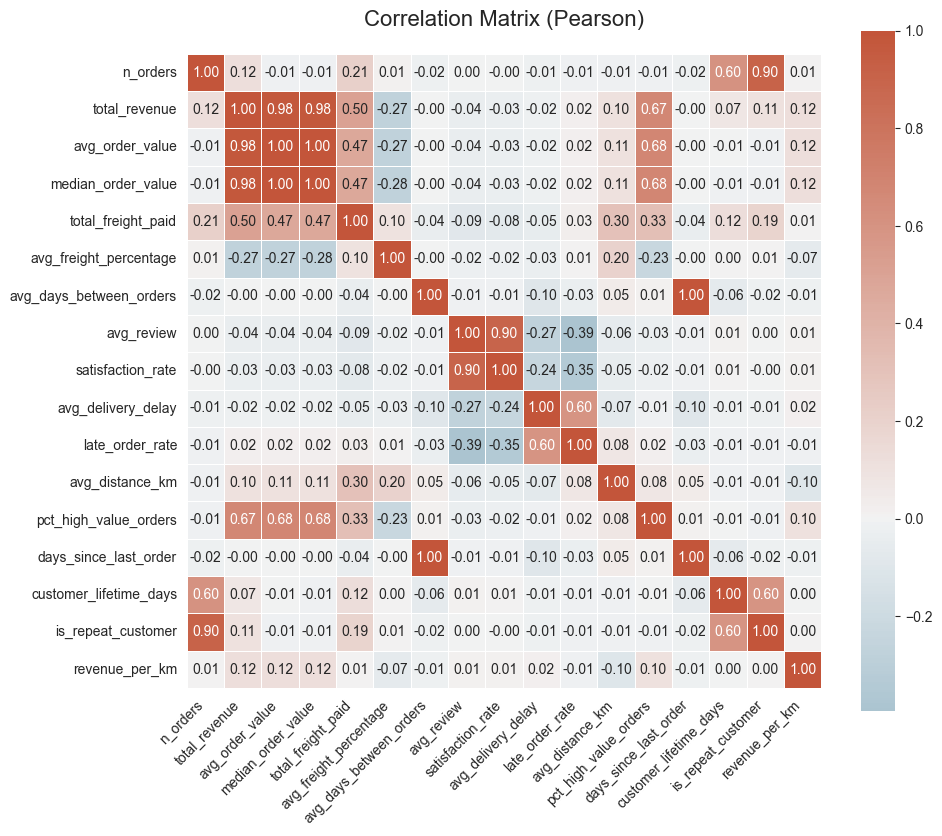

In [131]:
# Compute correlation matrix
corrmat = df_customers[num_feat].corr(method='pearson')

# Define color palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(10, 10))
sns.heatmap(
    corrmat,
    annot=True,            # show correlation values
    fmt=".2f",             # format numbers to 2 decimals
    cmap=cmap,
    center=0,              # center the colormap at 0 (neutral correlation)
    square=True,           # make cells square
    linewidths=0.5,        # thin grid lines
    cbar_kws={'shrink': 0.75}  # shrink color bar for aesthetics
)
plt.title("Correlation Matrix (Pearson)", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### (ii) using hierarchical clustering viewed as a dendrogram

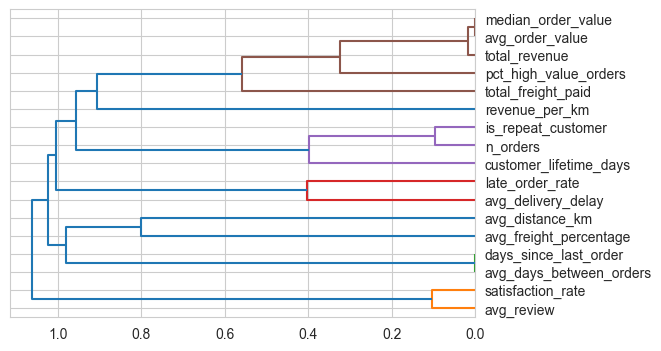

<Figure size 640x480 with 0 Axes>

In [132]:
from scipy.cluster import hierarchy as hc
from sklearn.preprocessing import StandardScaler

def cluster_columns(df):
    corr = df.corr()
    corr_condensed = hc.distance.squareform(1 - corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(6, 4))
    dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=10)
    plt.show()
    plt.tight_layout()

cluster_columns(df_customers[num_feat])

## based on the dendrogram, we exclude the redundant features:
redundant_num_features = ['median_order_value','total_revenue','late_order_rate','avg_days_between_orders','satisfaction_rate']
df_customers = df_customers.copy().drop(columns=redundant_num_features)

#### Numerically encode the categorical variables for (possible) subsequent analyses

In [133]:
## for this we create another version of the dataset
df_customers_num = df_customers.copy()

## encode the categorical variable:
LE = LabelEncoder() # Creates an instance of LabelEncoder from sklearn.preprocessing
for i in cat_feat:
    df_customers_num[i] = df_customers_num[[i]].apply(LE.fit_transform)
# fit_transform does two things: fit() learns all unique categories in that column, and transform() maps each category to a unique integer

## Customer Segmentation

#### (i) RFM-focused

we start with the classic approach for customer segmentation
- Recency (R): Measures how recently a customer made a purchase. Recent buyers are typically more active and more likely to purchase again.
- Frequency (F): Captures how often a customer buys. Frequent purchasers indicate higher loyalty and engagement, while infrequent ones may need reactivation efforts.
- Monetary (M): Assesses the total amount a customer has spent. High-spending customers are the most valuable, while lower spenders may require targeted strategies to increase their contribution.

In [134]:

#### create an RFM dedicated table
df_RFM = df_customers[['days_since_last_order', 'n_orders', 'avg_order_value']].copy()
df_RFM.rename(columns={
    'days_since_last_order': 'recency',
    'n_orders': 'frequency',
    'avg_order_value': 'monetary'
}, inplace=True)

#### scale the RFM values
scaler = StandardScaler() # create an instance of StandardScaler
RFM_scaled = scaler.fit_transform(df_RFM[['recency', 'frequency', 'monetary']])
print(RFM_scaled)
# fit_transform() does two things:
#   1. "fit" : calculates the mean and standard deviation for each column.
#   2. "transform" : scales each column so that it has mean = 0 and standard deviation = 1.



[[-0.82914758 -0.16212693 -0.08377313]
 [-0.80949118 -0.16212693 -0.60564175]
 [ 1.96206095 -0.16212693 -0.3370871 ]
 ...
 [ 2.16517706 -0.16212693 -0.21770925]
 [-0.77673052 -0.16212693 -0.1211242 ]
 [ 1.61479791 -0.16212693 -0.40378219]]


---> Determine the number of cluster using the "Elbow method"
It consists in plotting Within-Cluster Sum of Squares (WCSS) vs number of clusters.
And look for the “elbow” point where adding more clusters doesn’t reduce WCSS much

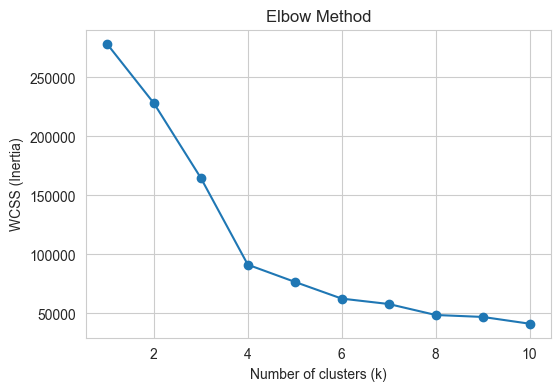

In [135]:

wcss = [] # empty list to store WCSS values
K_range = range(1, 11)  # Try 1 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(RFM_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(K_range, wcss, marker='o')
ax.set_xlabel('Number of clusters (k)') ; ax.set_ylabel('WCSS (Inertia)') ; ax.set_title('Elbow Method')
plt.show() # looks like the WCSS stops dropping steeply after 5 clusters

## ---> 4 cluster looks optimal

#### K-mean Clustering

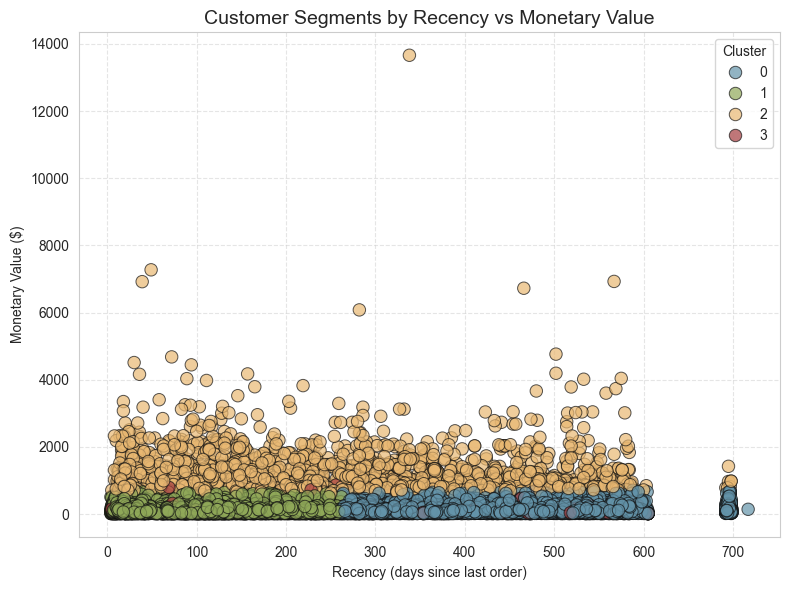

In [136]:

cluster_nb = 4
kmeans = KMeans(n_clusters = cluster_nb, random_state = 42)

# Fit the KMeans model to the scaled RFM data.
kmeans.fit(RFM_scaled)

# add a new column 'Cluster' to the original rfm DataFrame with the cluster labels.
df_RFM['cluster'] = kmeans.labels_


### plot the 'natural groupings' find with KMeans clusters

# Define color palette for clusters
colors = ["#6494AA", "#90A959", "#E9B872", "#A63D40"]

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
    x='recency',
    y='monetary',
    hue='cluster',        # color points by cluster
    palette=colors,       # custom cluster colors
    data=df_RFM,
    s=80,                 # marker size
    alpha=0.7,            # transparency for overlap
    edgecolor='k',        # black border for visibility
    ax=ax                 # specify the axes
)
# Customize axes
ax.set_title("Customer Segments by Recency vs Monetary Value", fontsize=14)
ax.set_xlabel("Recency (days since last order)")
ax.set_ylabel("Monetary Value ($)")
ax.legend(title='Cluster')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

/var/folders/p_/2z_4h86x4xn1vn6dsptg3n000000gn/T/ipykernel_31676/3877307441.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_RFM.groupby('cluster').apply(


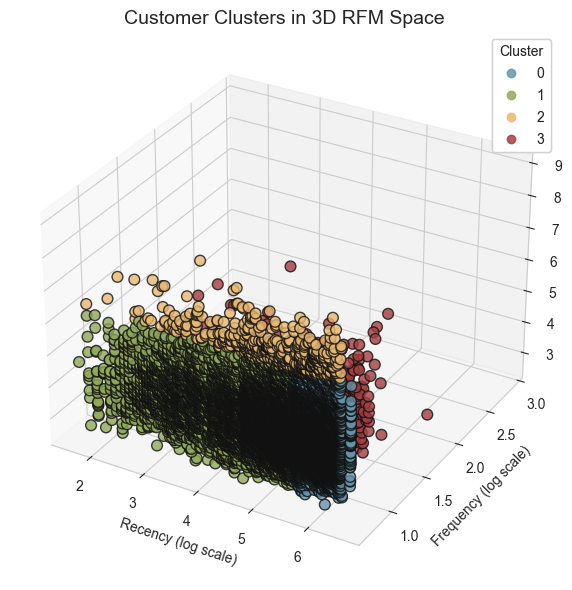

In [137]:
#### visualize the clusters formed with 3D scatterplot

### Subsample before plotting because the large number of rows slow down the 3D visualization!
df_sampled = df_RFM.groupby('cluster').apply(
    lambda x: x.sample(frac=0.2, random_state=42) # Sample 20% from each cluster
).reset_index(drop=True)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    np.log1p(df_sampled["recency"]),
    np.log1p(df_sampled["frequency"]),
    np.log1p(df_sampled["monetary"]),
    s=60,  # marker size
    c=df_sampled["cluster"],  # cluster labels for color
    cmap=matplotlib.colors.ListedColormap(colors),  # custom colors
    marker='o',
    alpha=0.8,
    edgecolor='k'  # black edge for better visibility
)
ax.set_title("Customer Clusters in 3D RFM Space", fontsize=14)
ax.set_xlabel("Recency (log scale)")
ax.set_ylabel("Frequency (log scale)")
ax.set_zlabel("Monetary (log scale)")
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)
plt.tight_layout()
plt.show()

In [138]:
# *** ---> The classical RFM approach shows that Frequency here is not very informative, as the dataset contains few repeated buyers
print(f"There are {df_customers.shape[0]} customers, but only {(df_customers['n_orders'] > 1).sum()} (3.1%) of them made multiple orders")
## even within the 3% of repeated customer, most of them made only 2 orders:
df_customers['n_orders'][df_customers['is_repeat_customer']==True].describe()

There are 92874 customers, but only 2898 (3.1%) of them made multiple orders


count    2898.000000
mean        2.114562
std         0.520868
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        17.000000
Name: n_orders, dtype: float64

#### (ii) All features

Contrary to the RFM-focused approach, here we use all available features to segment customers

#### Dimensionality Reduction

In [139]:
### Scale the data before dimensionality reduction
### (to avoid having the PCA dominated by the feature with the largest numeric range)

## exclude columns that don't make sense having in the PCA
features_to_exclude = ['state', 'city', 'dominant_review_category','customer_unique_id', 'first_order_date', 'last_order_date']
df_customers_scaled = df_customers_num.copy().drop(columns=features_to_exclude)

scaler = StandardScaler()
scaler.fit(df_customers_scaled)
df_customers_scaled = pd.DataFrame(scaler.transform(df_customers_scaled),columns= df_customers_scaled.columns )
print("All features are now scaled")

# Segmenting the data can be done according to  many features, some of which are correlated and redundant.
# To simplify the data and improve classification, we perform dimensionality reduction with PCA, which reduces the number of variables by extracting the most important ones.

# Initiate PCA to reduce dimensions (features) to 3
pca = PCA(n_components=3)
# Fit PCA on the scaled dataset
pca.fit(df_customers_scaled)
# Transform the dataset and store as a new DataFrame with 3 principal components
PCA_df = pd.DataFrame(
    pca.transform(df_customers_scaled),
    columns=["PC1", "PC2", "PC3"]
)

PCA_df.head()
## check the percentage of variance explained by the principal components:
variance_ratio = pca.explained_variance_ratio_ * 100
print(f'var.expl.:   PC1: {round(variance_ratio[0],2)} ; PC2:{round(variance_ratio[1],2)} ; PC3:{round(variance_ratio[2],2)}')


All features are now scaled
var.expl.:   PC1: 20.85 ; PC2:17.44 ; PC3:11.78


#### Clustering

After reducing the dataset to three principal components using PCA, we'll apply clustering to group similar customers.


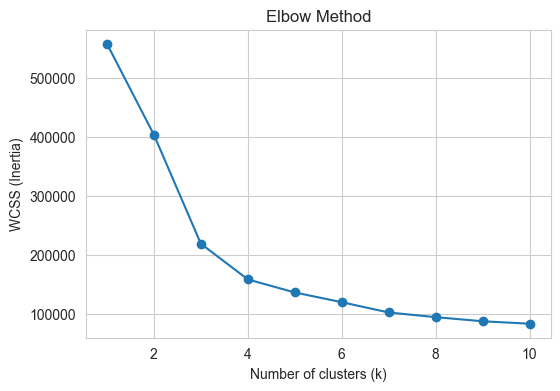

In [140]:

#---> Determine the number of cluster using the "Elbow method".

wcss = [] # empty list to store WCSS values
K_range = range(1, 11)  # Try 1 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(PCA_df)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(K_range, wcss, marker='o')
ax.set_xlabel('Number of clusters (k)') ; ax.set_ylabel('WCSS (Inertia)') ; ax.set_title('Elbow Method')
plt.show() # looks like the WCSS stops dropping steeply after 5 clusters

We shall look for the “elbow” point where adding more clusters doesn’t reduce score much.
---> The Elbow plot indicates that 4 will be an optimal number of clusters

#### K-Means Clustering

/var/folders/p_/2z_4h86x4xn1vn6dsptg3n000000gn/T/ipykernel_31676/3877417330.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = PCA_df.groupby('cluster').apply(


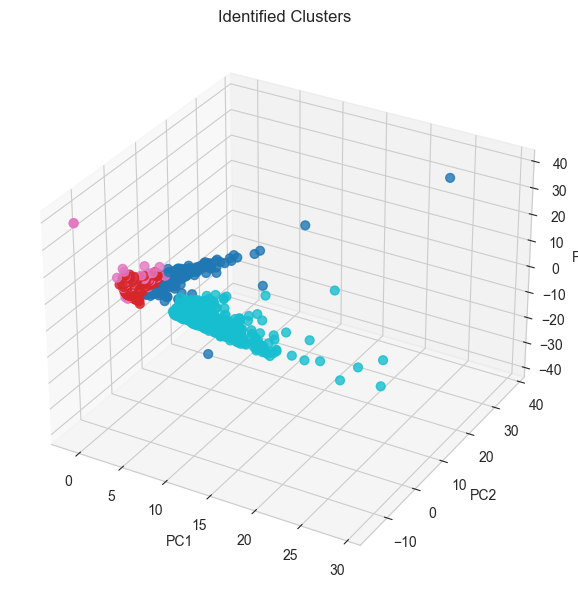

In [141]:
# K-Means creates a fixed number of non-overlapping clusters directly from the data.

# Create an instance of the KMeans clustering model.
cluster_nb = 4
kmeans = KMeans(n_clusters = cluster_nb, random_state = 42)

# Fit the KMeans model to the scaled data.
# The model learns the cluster centroids (i.e., the "average" points around which clusters form).
kmeans.fit(df_customers_scaled)

# Appends the same cluster labels to the original data, and to the PCA data
df_customers["cluster"]= kmeans.labels_
df_customers_scaled["cluster"]= kmeans.labels_
PCA_df["cluster"] = kmeans.labels_


#### Let's examine the clusters formed using a 3D scatterplot

## first we subsample the data for facilitate the visualization

# Subsample before plotting because the large number of rows slow down the 3D visualization!
df_sampled = PCA_df.groupby('cluster').apply(
    lambda x: x.sample(frac=0.3, random_state=42) # Sample 30% from each cluster
).reset_index(drop=True)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_sampled["PC1"], df_sampled["PC2"], df_sampled["PC3"],
    s=40,                      # marker size
    c=df_sampled["cluster"],# cluster labels for color
    cmap='tab10',               # color map
    marker='o',                 # shape
    alpha=0.8                   # transparency
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Identified Clusters")
plt.tight_layout()
plt.show()

### Interpreting Clusters

In [142]:

### extract the same set of feature used in the PCA - Kmeansclustering
df_customers_reduced = df_customers.copy().drop(columns=features_to_exclude)
# 'features_to_exclude' has been determined before the PCA
# 'df_customers_reduced' then includes the relevant and unscaled features

#### (i) Identify crucial features with RandomForests classifier

In [143]:

### A good approach is to implement a RandomForests classifier to predict cluster membership and look at feature importance
from sklearn.ensemble import RandomForestClassifier

X = df_customers_reduced.drop(columns=['cluster']) # 'df_customers_reduced' include the variable used for our clustering
y = df_customers_reduced['cluster']
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

avg_review                0.431708
pct_high_value_orders     0.161114
avg_order_value           0.146145
avg_delivery_delay        0.081394
n_orders                  0.051524
is_repeat_customer        0.047569
avg_freight_percentage    0.028095
customer_lifetime_days    0.014621
total_freight_paid        0.014433
revenue_per_km            0.009781
avg_distance_km           0.008399
days_since_last_order     0.005218
dtype: float64


These are the top 7 most important feature differentiation the clusters:

In [144]:
## Make a summary table of the identified important features
cluster_summary = df_customers_reduced.groupby('cluster')[[
    'avg_review', 'pct_high_value_orders', 'avg_order_value',
    'avg_delivery_delay', 'n_orders', 'is_repeat_customer', 'avg_freight_percentage'
]].mean().round(2)
## add the number of customers per cluster:
cluster_summary['count'] = df_customers_reduced['cluster'].value_counts()

print(cluster_summary)

         avg_review  pct_high_value_orders  avg_order_value  \
cluster                                                       
0              4.02                   1.00           614.20   
1              4.67                   0.00           109.21   
2              1.78                   0.00           116.90   
3              4.14                   0.08           144.66   

         avg_delivery_delay  n_orders  is_repeat_customer  \
cluster                                                     
0                    -12.43      1.00                 0.0   
1                    -13.41      1.00                 0.0   
2                     -4.24      1.00                 0.0   
3                    -12.60      2.11                 1.0   

         avg_freight_percentage  count  
cluster                                 
0                          9.39   8974  
1                         32.18  66443  
2                         37.32  14560  
3                         32.27   2897  


#### (ii) Visualize Cluster Characteristics

#### Box plots per important features:

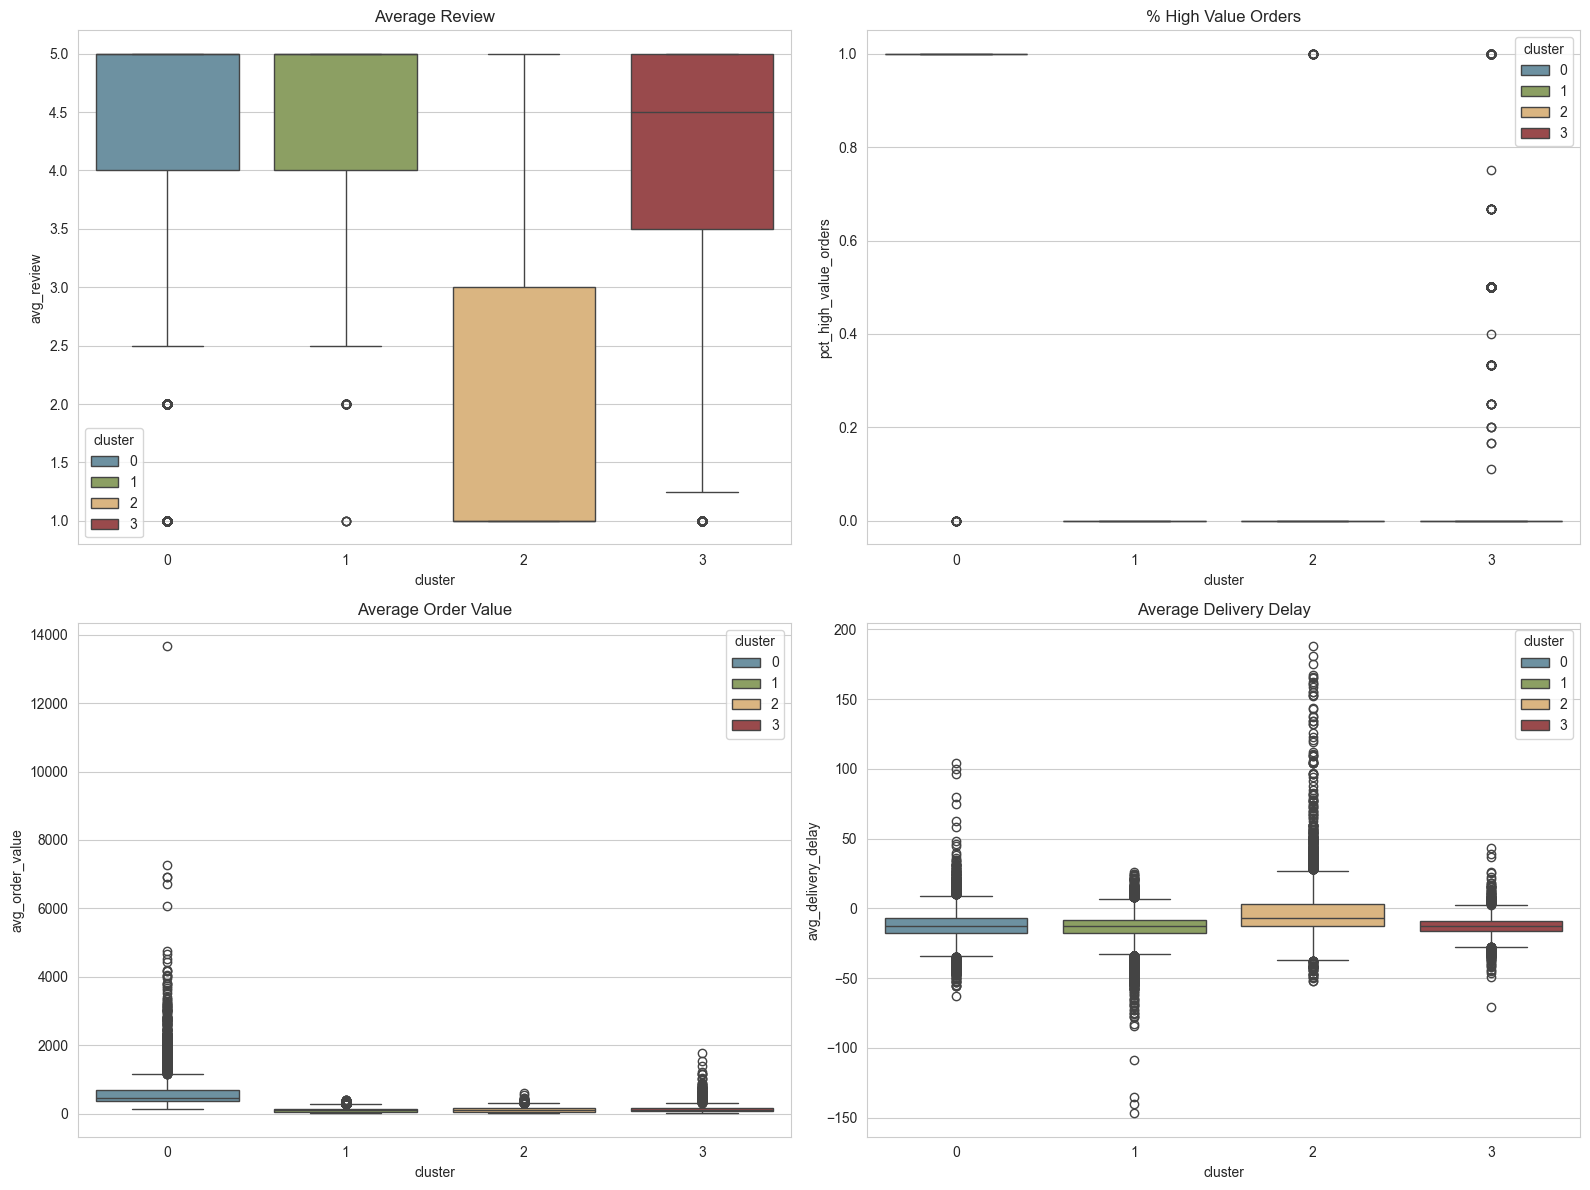

In [145]:

pal = ["#6494AA", "#90A959", "#E9B872", "#A63D40"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

features = [
    ("avg_review", "Average Review"),
    ("pct_high_value_orders", "% High Value Orders"),
    ("avg_order_value", "Average Order Value"),
    ("avg_delivery_delay", "Average Delivery Delay")
]

for ax, (feat, title) in zip(axes, features):
    sns.boxplot(
        data=df_customers_reduced,
        hue="cluster",
        x="cluster",
        y=feat,
        palette=pal,
        ax=ax
    )
    ax.set_title(title)

plt.tight_layout()
plt.show()


#### Create a Radar (or “spider”) charts

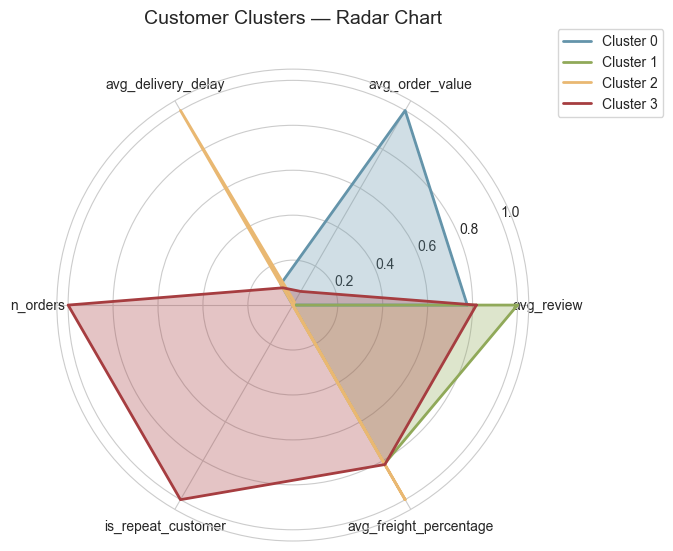

In [146]:

from sklearn.preprocessing import MinMaxScaler

###### (1) Select key features (identified through the RandomForests feature importance) and aggregate by cluster
features = [
    'avg_review', 'avg_order_value',
    'avg_delivery_delay', 'n_orders', 'is_repeat_customer', 'avg_freight_percentage'
]
# Compute mean of each feature per cluster
summarize_cluster = df_customers_reduced.groupby('cluster')[features].mean()

###### (2) Normalize to 0–1 scale so all axes are comparable
scaler = MinMaxScaler()
cluster_normalized = pd.DataFrame(
    scaler.fit_transform(summarize_cluster),
    columns=summarize_cluster.columns,
    index=summarize_cluster.index
)

###### (3) Create the radar chart
# Number of variables
categories = cluster_normalized.columns
N = len(categories)

# Set up the angle for each feature (divide full circle)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# Define color palette for clusters
colors = ["#6494AA", "#90A959", "#E9B872", "#A63D40"]


# Plot each cluster
fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True)) # Initialize the plot
for i, (idx, row) in enumerate(cluster_normalized.iterrows()):
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=f'Cluster {idx}', color=colors[i])  # line color
    ax.fill(angles, values, color=colors[i], alpha=0.3)  # fill color

# Add labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_title("Customer Clusters — Radar Chart", size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

#### Inspect what happens in cluster 2 regarding delivery delay and freight percentage:

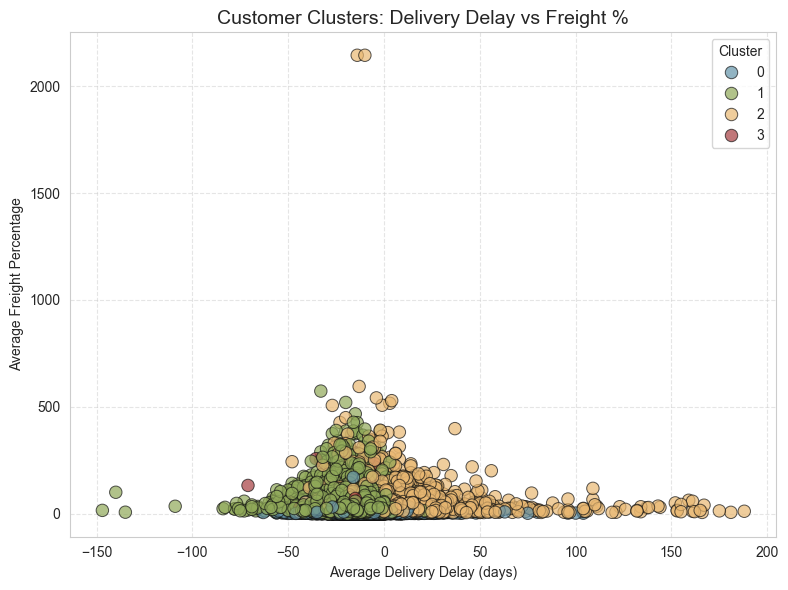

In [147]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='avg_delivery_delay',
    y='avg_freight_percentage',
    hue='cluster',                 # color points by cluster
    palette=colors,
    data=df_customers,
    s=80,                          # marker size
    alpha=0.7,                     # transparency
    edgecolor='k'                  # black border around points
)

plt.title("Customer Clusters: Delivery Delay vs Freight %", fontsize=14)
plt.xlabel("Average Delivery Delay (days)")
plt.ylabel("Average Freight Percentage")
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Summarize Cluster Insights

After performing clustering and Random Forest feature analysis,
four distinct customer segments were identified based on purchasing behavior,
satisfaction, and delivery experience.

- Cluster 0 – High-Value Premium Buyers:
Customers with the highest spending per order (≈ 192 USD) and strong satisfaction (4.0/5).
They purchase high-value products and experience early deliveries.
Although mostly one-time buyers, they represent highly profitable transactions.

- Cluster 1 – Satisfied Low-Spending Shoppers:
The largest group, making single, low-value purchases (34 BRL) with excellent satisfaction (4.7/5).
They experience early deliveries and pay relatively high freight costs.
Represent happy but casual customers with low long-term engagement.

- Cluster 2 – Unsatisfied Low-Spending Shoppers:
Lowest satisfaction segment (1.8/5) with small purchases (37 BRL).
Deliveries are slower, and freight costs are high (37% of total order value).
This group highlights potential service and logistics issues affecting customer experience.

- Cluster 3 – Loyal Repeat Customers:
The only segment with repeat purchasing behavior (2 orders per customer).
They are satisfied (4.1/5), buy moderately priced items (45 BRL),
and maintain average freight costs.
This cluster represents loyal, consistent customers and a key retention opportunity.

### Clusters through the Order-Level Dataset

Let's analyze how the clusters identified at the customer level behave at the order level.
We can do thi by merging the cluster label back into your order-level dataset.

In [148]:
# Merge cluster labels back into the order-level dataset
df_orders = df_orders.merge(
    df_customers[['customer_unique_id', 'cluster']],
    on='customer_unique_id',
    how='left'
)

#### RandomForests classifier

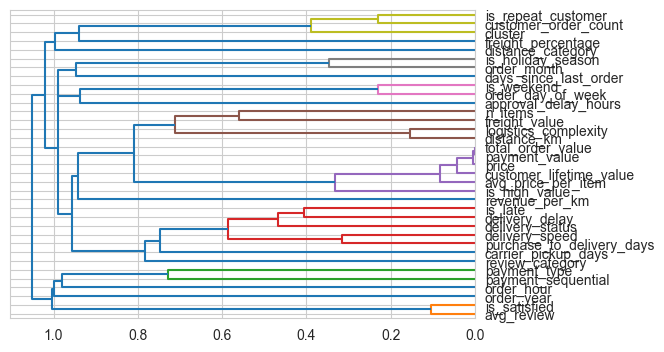

<Figure size 640x480 with 0 Axes>

In [149]:

## we follow a similar approach as before to identify the most important features differentiating the clusters at the order level

##### First we want to remove irrelevant or leakage columns
# These columns either:
# - IDs (no predictive value),
# - timestamps (too granular / not useful for classification),
# - are derived directly from the cluster (data leakage).

drop_cols = [ # columns to drop
    'order_id', 'customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
    'customer_city', 'customer_state',
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'customer_last_order']
df_orders_reduced = df_orders.drop(columns=drop_cols)

##### Then we want to numerically encode the categorical variables
##### (because tree-based methods don’t assume order, we can simply use Label Encoding here, and not one-hot encoding)

# Convert categorical columns to category dtype first
cat_cols = df_orders_reduced.select_dtypes(include='object').columns
for col in cat_cols:
    df_orders_reduced[col] = df_orders_reduced[col].astype('category').cat.codes

### Check and remove "inf" values in the data
np.isinf(df_orders.select_dtypes(include=[np.number])).any() # 'revenue_per_km' has some "inf" values
df_orders_reduced = df_orders_reduced[np.isfinite(df_orders_reduced['revenue_per_km'])] # Keep only rows where 'revenue_per_km' is finite (not inf or -inf)

### Check and remove "NaN" values in the data
df_orders_reduced.isnull().sum()
df_orders_reduced = df_orders_reduced.dropna()

### Remove th column 'order_status' because it has only one unique value
df_orders_reduced = df_orders_reduced.loc[:, df_orders_reduced.nunique() > 1]

### check for highly correlated numeric variables:
cluster_columns(df_orders_reduced.select_dtypes(include=[np.number]))


In [152]:
df_orders_reduced.dtypes

delivery_delay               float64
purchase_to_delivery_days    float64
freight_value                float64
n_items                      float64
payment_sequential           float64
payment_type                    int8
distance_km                  float64
order_year                     int64
order_month                    int64
order_day_of_week              int64
order_hour                     int64
is_weekend                     int64
is_holiday_season              int64
approval_delay_hours         float64
carrier_pickup_days          float64
avg_price_per_item           float64
freight_percentage           float64
revenue_per_km               float64
is_high_value                  int64
delivery_status                 int8
is_late                        int64
delivery_speed                  int8
is_satisfied                   int64
distance_category               int8
logistics_complexity         float64
customer_order_count           int64
customer_lifetime_value      float64
d

In [ ]:
## based on the dendrogram, we exclude the redundant features:
redundant_num_features = ['is_repeat_customer', 'price', 'total_order_value', 'payment_value', 'avg_review', 'review_category']
df_orders_reduced = df_orders_reduced.drop(columns=redundant_num_features)
cluster_columns(df_orders_reduced.select_dtypes(include=[np.number])) # re-plot the dendrogram until no more redundant features

#### fit the RandomForests classifier to identify important features

In [155]:
X = df_orders_reduced.drop(columns=['cluster'])
y = df_orders_reduced['cluster']
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

is_satisfied                 0.311803
customer_order_count         0.180859
customer_lifetime_value      0.129685
is_high_value                0.100241
avg_price_per_item           0.073961
delivery_delay               0.037041
freight_percentage           0.028253
is_late                      0.019559
purchase_to_delivery_days    0.014889
freight_value                0.013879
revenue_per_km               0.012670
days_since_last_order        0.009626
logistics_complexity         0.009582
distance_km                  0.008860
approval_delay_hours         0.007628
delivery_speed               0.006562
delivery_status              0.006562
n_items                      0.005490
order_hour                   0.005466
carrier_pickup_days          0.004302
order_month                  0.004124
order_day_of_week            0.003563
distance_category            0.001345
payment_type                 0.001276
order_year                   0.000936
is_weekend                   0.000847
is_holiday_s

In [157]:
## check the number of orders per cluster:
print(f"Number of orders belonging to each customer cluster: {df_orders_reduced['cluster'].value_counts()}")

Number of orders belonging to each customer cluster: cluster
1.0    66431
2.0    14559
0.0     8973
3.0     5992
Name: count, dtype: int64


#### Create a Radar charts

Number of orders belonging to each customer cluster: cluster
1.0    66431
2.0    14559
0.0     8973
3.0     5992
Name: count, dtype: int64


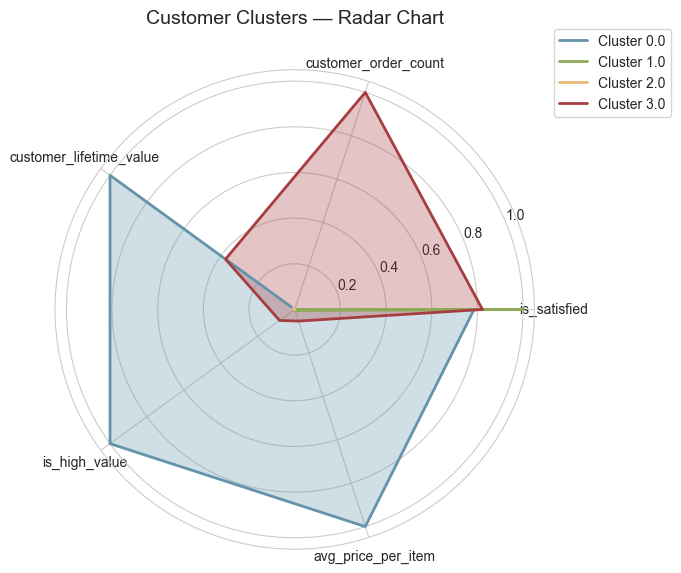

In [156]:
###### (1) Select key features and aggregate by cluster
features = [
    'is_satisfied', 'customer_order_count', 'customer_lifetime_value',
    'is_high_value', 'avg_price_per_item'
]
# Compute mean of each feature per cluster
summarize_cluster = df_orders_reduced.groupby('cluster')[features].mean()


###### (2) Normalize to 0–1 scale so all axes are comparable
scaler = MinMaxScaler()
cluster_normalized = pd.DataFrame(
    scaler.fit_transform(summarize_cluster),
    columns=summarize_cluster.columns,
    index=summarize_cluster.index
)

###### (3) Create the radar chart
# Number of variables
categories = cluster_normalized.columns
N = len(categories)

# Set up the angle for each feature (divide full circle)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# Initialize the plot
fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

# Define color palette for clusters
colors = ["#6494AA", "#90A959", "#E9B872", "#A63D40"]

# Plot each cluster
for i, (idx, row) in enumerate(cluster_normalized.iterrows()):
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=f'Cluster {idx}', color=colors[i])  # line color
    ax.fill(angles, values, color=colors[i], alpha=0.3)  # fill color


# Add labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_title("Customer Clusters — Radar Chart", size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


---> cluster 2 is very low-activity, low-value, dissatisfied customers. That’s why it barely appears visually.

### Clusters through the Product-Level Dataset

Here we want to analyze which products are mostly bought by each customer cluster.
However, 'customer_unique_id' is not present in 'df_products'
The connection is through 'order_id' → 'df_orders' → 'customer_unique_id'

In [158]:
# (1) Merge df_products with df_orders to get customer_unique_id for each product:
df_products = df_products.merge(
    df_orders[['order_id', 'customer_unique_id']],  # select only necessary columns
    on='order_id',
    how='left'  # keep all products
)
# (2) Merge the result with df_customers to get the cluster label:
df_products = df_products.merge(
    df_customers[['customer_unique_id', 'cluster']],
    on='customer_unique_id',
    how='left'
)
### After these two merges, df_products will have:
# - customer_unique_id
# - cluster (from df_customers)
# - All product-level features

print(df_products.dtypes)


order_id                          object
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
shipping_cost_ratio              float64
product_weight_g                 float64
seller_zip_code_prefix             int64
seller_city                       object
seller_state                      object
product_category_name_english     object
seller_lat                       float64
seller_lng                       float64
item_share_of_order              float64
weight_per_dollar                float64
freight_per_gram                 float64
is_heavy_product                   int64
is_premium                         int64
seller_order_count                 int64
seller_avg_price                 float64
is_top_seller                      int64
customer_state                    object
is_local_transac

#### RandomForests classifier

In [159]:
## we follow a similar approach as before to identify the most important features differentiating the clusters at the product level

##### First we want to remove irrelevant or leakage columns

### These columns are unique or categorical IDs that do not carry predictive value themselves:
# 'order_id' → Each product row is unique per order; we don’t want the model to memorize IDs.
# 'order_item_id' → Sequential ID of items in the order; not meaningful.
# 'product_id' → Unique product identifier; RF can’t generalize on this.
# 'seller_id' → Unique seller; might be high-cardinality categorical.
# 'customer_unique_id' → Already have cluster as target; ID itself is meaningless.
# 'shipping_limit_date' → Could engineer shipping month/day if relevant, otherwise exclude.
### Random Forests cannot handle strings; these need encoding (e.g., cat.code or one-hot) or exclusion if too many unique values:
# 'product_category_name_english' → not relevant
# seller_city → High-cardinality; likely better to exclude.
drop_cols = [
    'order_id', 'order_item_id', 'product_id', 'seller_id',
    'customer_unique_id', 'product_category_name_english',
    'seller_city', 'shipping_limit_date'
]
df_products_reduced = df_products.drop(columns=drop_cols)

In [160]:
##### Then we want to numerically encode some of the categorical variables
##### (because tree-based methods don’t assume order, we can simply use Label Encoding here, and not one-hot encoding)

### let's encode 'seller_state' and 'customer_state'
df_products_reduced['seller_state'] = df_products_reduced['seller_state'].astype('category').cat.codes
df_products_reduced['customer_state'] = df_products_reduced['customer_state'].astype('category').cat.codes

### Check and remove "inf" values in the data
np.isinf(df_products_reduced.select_dtypes(include=[np.number])).any() # 'freight_per_gram' has some "inf" values
df_products_reduced = df_products_reduced[np.isfinite(df_products_reduced['freight_per_gram'])] # Keep only rows where 'freight_per_gram' is finite (not inf or -inf)

### Check and remove "NaN" values in the data
df_products_reduced.isnull().sum()
df_products_reduced = df_products_reduced.dropna()

### Remove th column 'order_status' because it has only one unique value
print(f"number of unique values per column:\n {df_orders_reduced.nunique()}") # no column with only one unique value here

number of unique values per column:
 delivery_delay                 198
purchase_to_delivery_days      146
freight_value                 7599
n_items                         17
payment_sequential              19
payment_type                     4
distance_km                  90258
order_year                       3
order_month                     12
order_day_of_week                7
order_hour                      24
is_weekend                       2
is_holiday_season                2
approval_delay_hours         32492
carrier_pickup_days             69
avg_price_per_item            6930
freight_percentage           43239
revenue_per_km               95319
is_high_value                    2
delivery_status                  3
is_late                          2
delivery_speed                   5
is_satisfied                     2
distance_category                5
logistics_complexity         91279
customer_order_count             9
customer_lifetime_value       8248
days_since_last_or

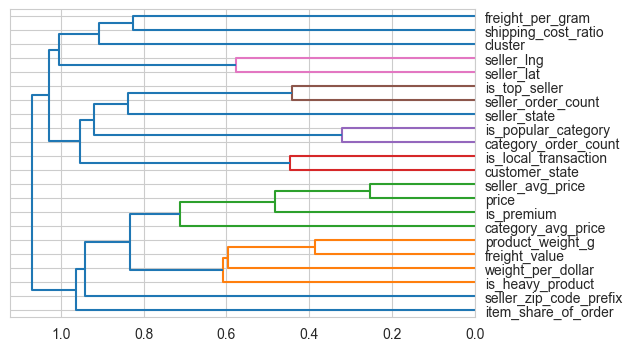

<Figure size 640x480 with 0 Axes>

In [161]:
### check for highly correlated numeric variables:
cluster_columns(df_products_reduced.select_dtypes(include=[np.number]))
## based on the dendrogram, we exclude the redundant features:
redundant_num_features = ['product_weight_g','freight_value', 'weight_per_dollar','shipping_cost_ratio']
df_products_reduced = df_products_reduced.drop(columns=redundant_num_features)

#### fit the RandomForests classifier to identify important features

In [162]:
X = df_products_reduced.drop(columns=['cluster'])
y = df_products_reduced['cluster']
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

price                     0.294464
freight_per_gram          0.203510
item_share_of_order       0.109694
customer_state            0.078293
seller_avg_price          0.060693
is_premium                0.038379
seller_order_count        0.036859
seller_zip_code_prefix    0.033015
seller_lng                0.032940
seller_lat                0.032684
category_avg_price        0.027190
category_order_count      0.025652
is_heavy_product          0.008561
is_local_transaction      0.005342
seller_state              0.005007
is_top_seller             0.004654
is_popular_category       0.003061
dtype: float64


Number of products associated with each customer cluster: cluster
1.0    71398
2.0    17344
0.0    12119
3.0     7302
Name: count, dtype: int64


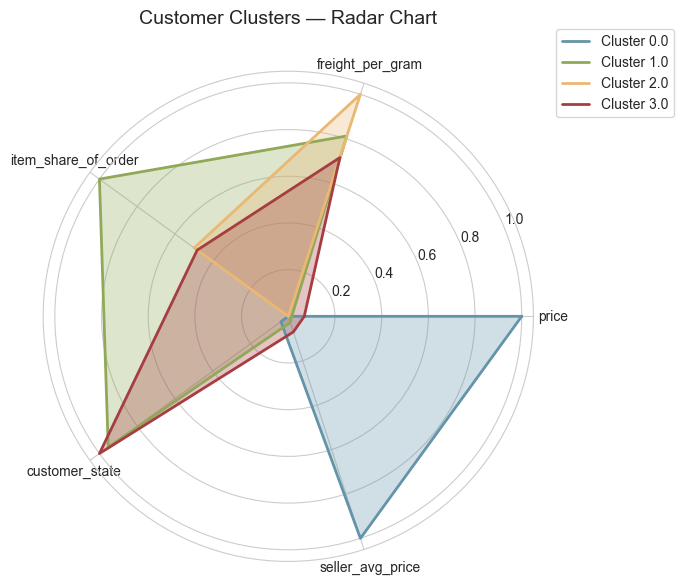

In [163]:
###### (1) Select key features and aggregate by cluster
features = [
    'price', 'freight_per_gram', 'item_share_of_order',
    'customer_state', 'seller_avg_price'
]
# Compute mean of each feature per cluster
summarize_cluster = df_products_reduced.groupby('cluster')[features].mean()

## check the number of orders per cluster:
print(f"Number of products associated with each customer cluster: {df_products_reduced['cluster'].value_counts()}")

###### (2) Normalize to 0–1 scale so all axes are comparable
scaler = MinMaxScaler()
cluster_normalized = pd.DataFrame(
    scaler.fit_transform(summarize_cluster),
    columns=summarize_cluster.columns,
    index=summarize_cluster.index
)

###### (3) Create the radar chart
# Number of variables
categories = cluster_normalized.columns
N = len(categories)

# Set up the angle for each feature (divide full circle)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# Initialize the plot
fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

# Define color palette for clusters
colors = ["#6494AA", "#90A959", "#E9B872", "#A63D40"]

# Plot each cluster
for i, (idx, row) in enumerate(cluster_normalized.iterrows()):
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=f'Cluster {idx}', color=colors[i])  # line color
    ax.fill(angles, values, color=colors[i], alpha=0.3)  # fill color

# Add labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_title("Customer Clusters — Radar Chart", size=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


## Sales Metrics

In [165]:
# Convert Brazilian Real in US dollar assuming this conversion rate (it's the rate of 2017))
BRL_to_USD = 0.3134
df_orders['total_order_value_usd'] = df_orders['total_order_value'] * BRL_to_USD

#### Average annual sale and number of orders

In [166]:
#### Grand Total
valid_orders_df = df_orders[df_orders['order_delivered_customer_date'].notna()]
grand_tot = valid_orders_df['total_order_value_usd'].sum()
print(f"The total sales on the period 2016-2018 is {grand_tot:.0f} USD")

The total sales on the period 2016-2018 is 4832125 USD


#### Average per year

In [167]:
# ---> There is 1.995 years (≈728.5 days) between the first and last order in the dataset
print(f"The average yearly sale on the period 2016-2018 is {grand_tot/1.995:.0f} USD, with an average of {96470/1.995:.0f} orders per year")

The average yearly sale on the period 2016-2018 is 2422118 USD, with an average of 48356 orders per year


#### Average Order Value (AOD)

In [168]:
AOV_usd = valid_orders_df['total_order_value_usd'].mean()
print(f"The average order value for delivered orders is {AOV_usd:.2f} USD")

The average order value for delivered orders is 50.09 USD


#### Geographic area contributing the most

In [169]:
sales_by_state = (
    df_orders
    .groupby('customer_state', as_index=False)['total_order_value_usd']
    .sum()
    .sort_values(by='total_order_value_usd', ascending=False)
)
# Compute percentage of total sales
total_sales = sales_by_state['total_order_value_usd'].sum()
sales_by_state['percent_of_total'] = (sales_by_state['total_order_value_usd'] / total_sales * 100).round(2)

print(f"The states SP, RJ and MG together represent {sales_by_state.iloc[0:3]['total_order_value_usd'].sum():.0f} USD \n"
      f"and {sales_by_state.iloc[0:3]['percent_of_total'].sum():.0f}% of total sales")



The states SP, RJ and MG together represent 3083462 USD 
and 63% of total sales


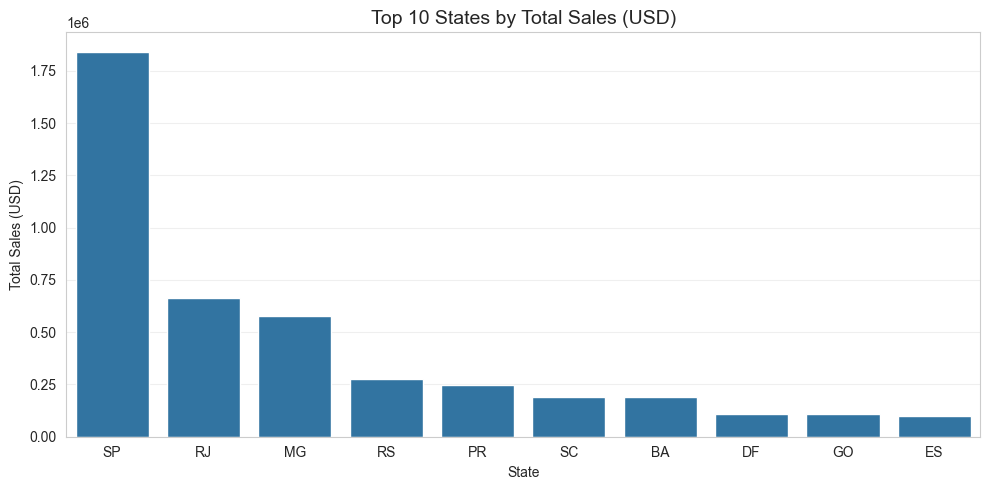

In [170]:
### Visualize the top 10 performing regions:
top_states = sales_by_state.head(10)
plt.figure(figsize=(10,5))
sns.barplot(
    data=top_states,
    x='customer_state',
    y='total_order_value_usd',
)
plt.title('Top 10 States by Total Sales (USD)', fontsize=14)
plt.xlabel('State')
plt.ylabel('Total Sales (USD)')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Sales Trend Over Time

In [174]:
## convert 'order_purchase_timestamp' to proper datetime type
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], errors='coerce')

#### Sales over time (per months)

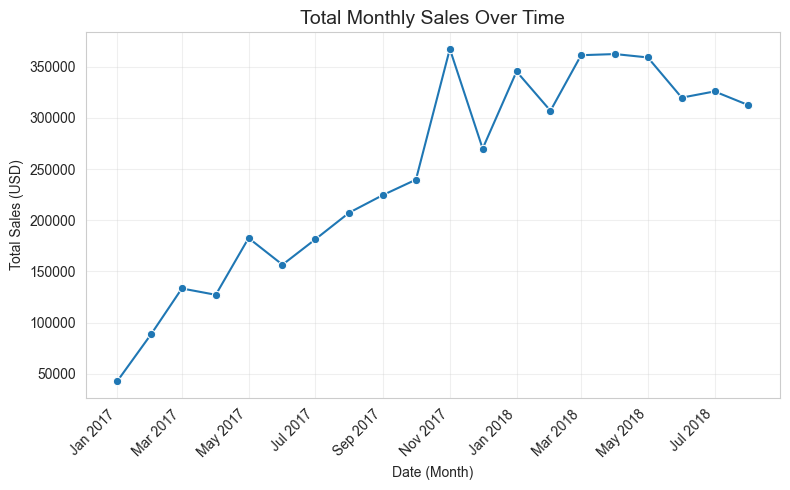

In [175]:
## Compute total sales per month
sales_by_month = (df_orders.groupby(['order_year','order_month'])['total_order_value_usd'].sum().reset_index())
## Create a proper datetime column for plotting
sales_by_month['date'] = pd.to_datetime(
    sales_by_month['order_year'].astype(str) + '-' + sales_by_month['order_month'].astype(str) + '-01'
)
## remove the last row because it has unrealistic low total_order_value_usd
sales_by_month = sales_by_month.drop(sales_by_month.index[-1])


### total order value
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(
    data=sales_by_month[3:], # make the first data point be January 2017
    x='date',
    y='total_order_value_usd',
    marker='o',
    ax=ax,
    color='tab:blue'
)
ax.set_title("Total Monthly Sales Over Time", fontsize=14)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("Total Sales (USD)")
ax.grid(True, alpha=0.3)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right') # Rotate x-ticks for readability
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # clear month labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.tight_layout()
plt.show()

#### Average Order Value per Month

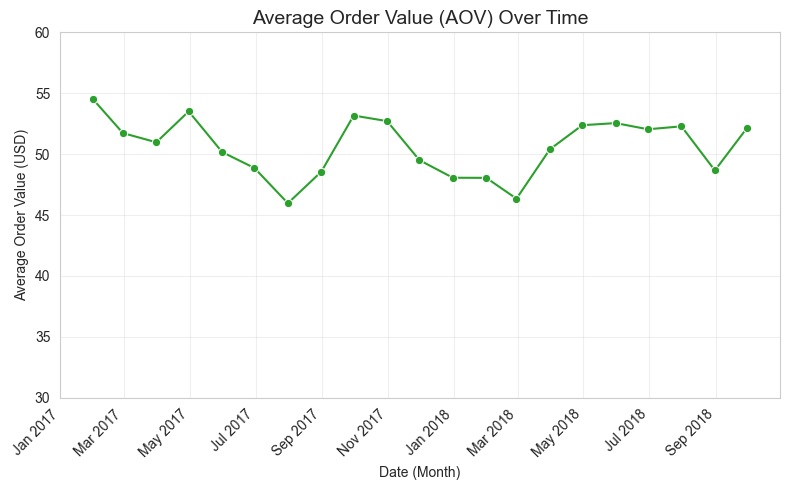

In [176]:
aov_by_month = (df_orders.set_index('order_purchase_timestamp').resample('ME')['total_order_value_usd'].mean().reset_index()
    .rename(columns={'order_purchase_timestamp': 'date', 'total_order_value_usd': 'avg_order_value_usd'}) )

fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(
    data=aov_by_month[4:], ## make it start at  2017-01-31 because there are too few orders before that date
    x='date',
    y='avg_order_value_usd',
    marker='o',
    ax=ax,
    color='tab:green'
)

ax.set_title("Average Order Value (AOV) Over Time", fontsize=14)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("Average Order Value (USD)")
ax.grid(True, alpha=0.3)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
# Show labels every 2 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.tight_layout()
ax.set_ylim(30, 60) # edit y axis lim
plt.show()

#### Growth rate per month

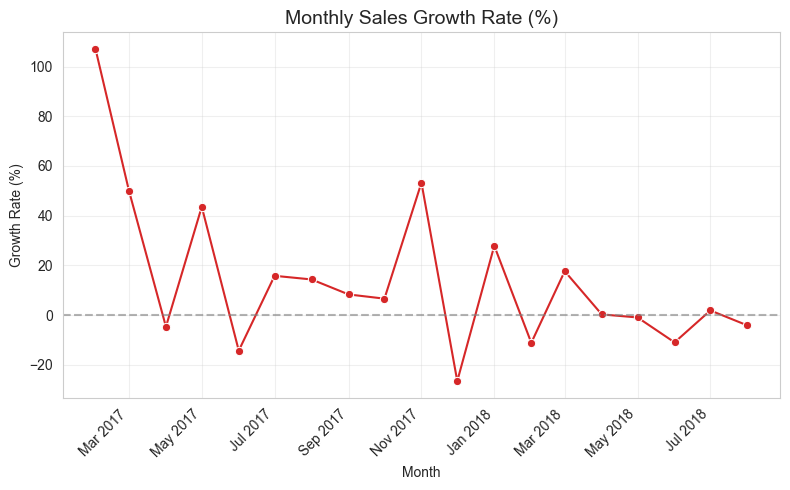

In [177]:
# Compute month-over-month growth rate
sales_by_month['growth_rate_%'] = sales_by_month['total_order_value_usd'].pct_change() * 100

fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(
    data=sales_by_month.loc[4:], # make it start after the 4th row to exclude noisy first values
    x='date',
    y='growth_rate_%',
    marker='o',
    color='tab:red',
    ax=ax
)
ax.axhline(0, color='gray', linestyle='--', alpha=0.6)
ax.set_title("Monthly Sales Growth Rate (%)", fontsize=14)
ax.set_xlabel("Month")
ax.set_ylabel("Growth Rate (%)")
ax.grid(True, alpha=0.3)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tight_layout()
plt.show()

In [182]:
growth_2017 = sales_by_month[(sales_by_month.order_year==2017)]['growth_rate_%']
growth_2017 = growth_2017.iloc[2:]
growth_2018 = sales_by_month[(sales_by_month.order_year==2018)]['growth_rate_%']

print(f'in 2017, the average growth rate was {growth_2017.mean():.1f}%, while in 2018, it was {growth_2018.mean():.1f}%')

in 2017, the average growth rate was 14.7%, while in 2018, it was 2.6%


#### Growth rate per Quarter

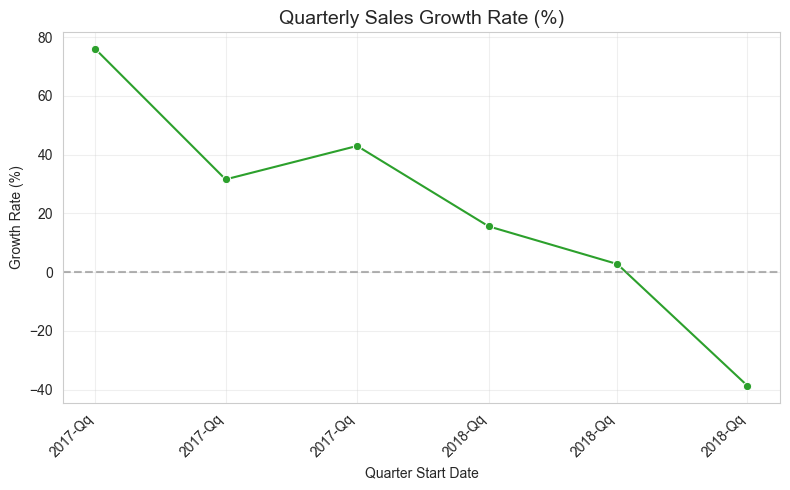

In [183]:
sales_indexed = sales_by_month.set_index('date')

# 2. Resample to Quarterly Sales (Quarter Start frequency) and sum sales.
quarterly_sales = (
    sales_indexed['total_order_value_usd']
    .resample('QS')  # 'QS' for Quarter Start frequency
    .sum()
)
# 3. Calculate Quarter-over-Quarter Growth Rate (%)
quarterly_sales_growth = pd.DataFrame({
    'date': quarterly_sales.index,
    'total_sales_usd': quarterly_sales.values,
    'quarterly_growth_rate_%': quarterly_sales.pct_change() * 100
})


fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(
    data=quarterly_sales_growth.iloc[3:], # filter noisy beggining
    x='date',
    y='quarterly_growth_rate_%',
    marker='o',
    color='tab:green',
    ax=ax
)
ax.axhline(0, color='gray', linestyle='--', alpha=0.6)
ax.set_title("Quarterly Sales Growth Rate (%)", fontsize=14)
ax.set_xlabel("Quarter Start Date")
ax.set_ylabel("Growth Rate (%)")
ax.grid(True, alpha=0.3)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-Q%q'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
fig.tight_layout()
plt.show()

### Clusters Over Time

#### Separate sales trend by clusters

In [185]:
sales_by_month_cluster = (df_orders.groupby([pd.Grouper(key='order_purchase_timestamp', freq='ME'), 'cluster'])['total_order_value_usd']
                            .sum()
                            .reset_index()
                           .sort_values('order_purchase_timestamp')
)

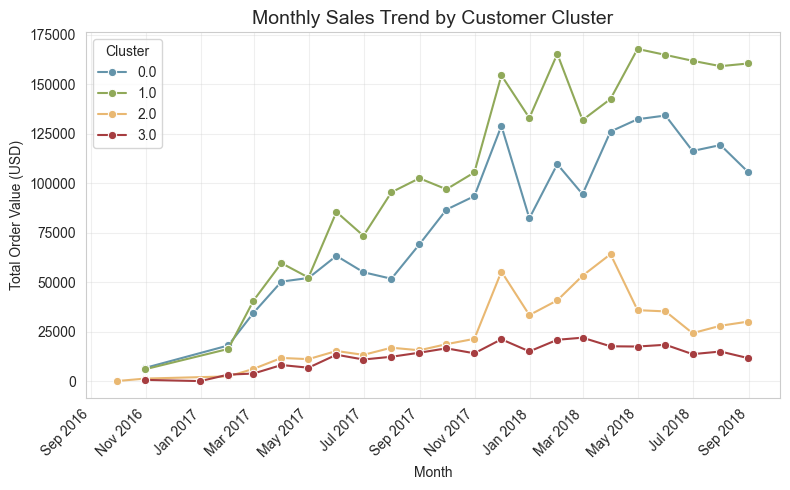

In [186]:
#---------------- Plot sales over time PER CLUSTERS
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(
    data=sales_by_month_cluster,
    x='order_purchase_timestamp',
    y='total_order_value_usd',
    hue='cluster',
    marker='o',
    ax=ax,
    palette=colors
)
ax.set_title("Monthly Sales Trend by Customer Cluster", fontsize=14)
ax.set_xlabel("Month")
ax.set_ylabel("Total Order Value (USD)")
ax.grid(True, alpha=0.3)

# Make the x-axis more readable
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

ax.legend(title="Cluster")
fig.tight_layout()
plt.show()

#### Plot proportion of total sales over time PER CLUSTERS

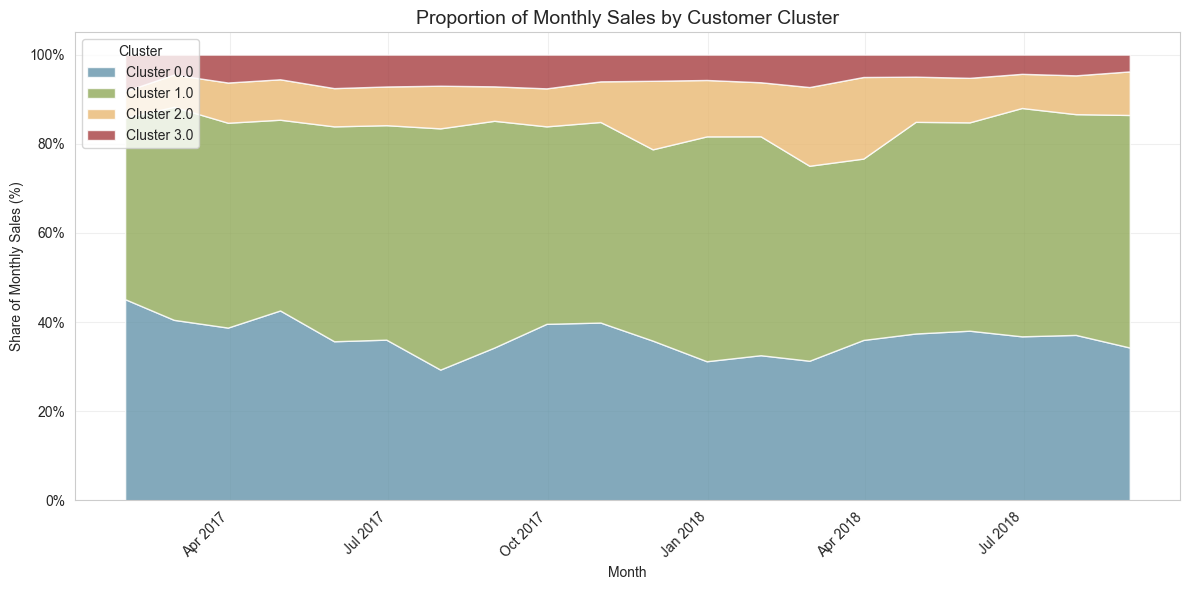

In [187]:
# --- Compute monthly sales per cluster ---
sales_by_month_cluster = (
    df_orders
    .groupby([pd.Grouper(key='order_purchase_timestamp', freq='ME'), 'cluster'])
    ['total_order_value_usd']
    .sum()
    .reset_index()
)

# --- Compute total sales per month ---
total_sales_per_month = (
    sales_by_month_cluster
    .groupby('order_purchase_timestamp')['total_order_value_usd']
    .sum()
    .reset_index()
    .rename(columns={'total_order_value_usd': 'total_sales'})
)

# --- Merge to get proportions ---
sales_by_month_cluster = sales_by_month_cluster.merge(total_sales_per_month, on='order_purchase_timestamp')
sales_by_month_cluster['sales_share'] = (
    sales_by_month_cluster['total_order_value_usd'] / sales_by_month_cluster['total_sales']
)


#---------------- Plot for Proportion of Sales (area plot) ----------------

# Pivot data to have clusters as columns
sales_pivot = sales_by_month_cluster.pivot(
    index='order_purchase_timestamp',
    columns='cluster',
    values='sales_share'
).fillna(0)  # fill missing values with 0 if any


### drop the first rows in 'sales_pivot' because data are noisy at the beginning
sales_pivot = sales_pivot.drop(sales_pivot.index[0:3])

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
# Stacked area plot
ax.stackplot(
    sales_pivot.index,
    sales_pivot.T,  # transpose so each row = cluster
    labels=[f'Cluster {c}' for c in sales_pivot.columns],
    colors=colors,
    alpha=0.8
)
ax.set_title("Proportion of Monthly Sales by Customer Cluster", fontsize=14)
ax.set_xlabel("Month")
ax.set_ylabel("Share of Monthly Sales (%)")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))  # % format

# X-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Legend
ax.legend(loc='upper left', title='Cluster')

# Grid and layout
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

---> the contribution of each cluster of total sale is stable over time

#### Assess seasonality by aggregating by month-of-year

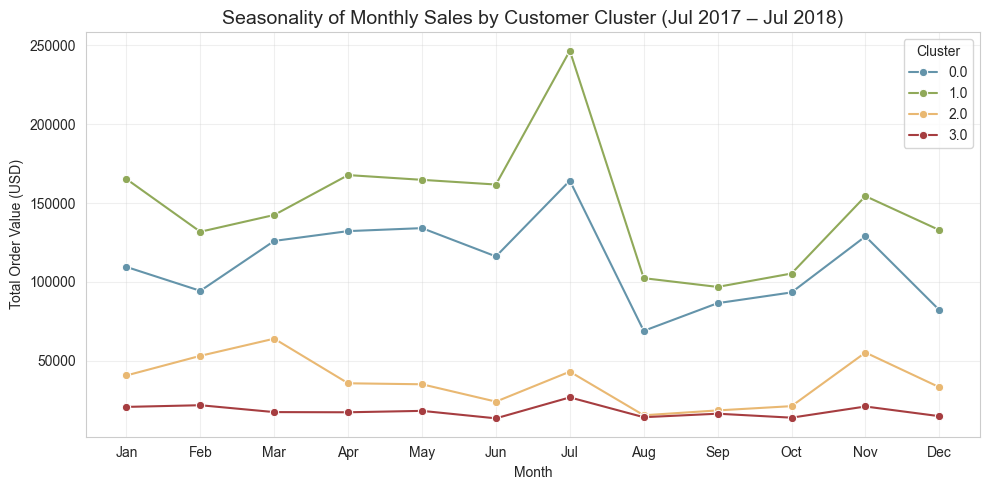

In [188]:
## Here we assess seasonal patterns in a period where order volume is comparable, avoiding biases from unbalanced order numbers across years.
# sns.histplot(data=df_orders.order_purchase_timestamp)
## ---> number of orders are comparable from july 2017 to July 2018

#---------------- Filter date range ----------------
start_date = "2017-07-01"
end_date = "2018-07-31"

df_filtered = df_orders[
    (df_orders['order_purchase_timestamp'] >= start_date) &
    (df_orders['order_purchase_timestamp'] <= end_date)
].copy()

# Extract month from timestamp
df_filtered['order_month'] = df_filtered['order_purchase_timestamp'].dt.month

# Compute total sales per cluster per month
sales_by_month_cluster_season = (
    df_filtered.groupby(['order_month', 'cluster'])['total_order_value_usd']
    .sum()
    .reset_index()
)

# Custom color palette for clusters
colors = ["#6494AA", "#90A959", "#E9B872", "#A63D40"]


#---------------- Plot seasonality per cluster ----------------
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(
    data=sales_by_month_cluster_season,
    x='order_month',
    y='total_order_value_usd',
    hue='cluster',
    marker='o',
    ax=ax,
    palette=colors
)

# Formatting
ax.set_title("Seasonality of Monthly Sales by Customer Cluster (Jul 2017 – Jul 2018)", fontsize=14)
ax.set_xlabel("Month")
ax.set_ylabel("Total Order Value (USD)")
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.grid(True, alpha=0.3)
ax.legend(title="Cluster")
fig.tight_layout()
plt.show()

---> There are two peaks of sales, one in July and another in November. But seasonality is hard to establish on only few years

## Product Trends

There are 71 different product categories. Let's divide them into 11 more general categories

In [189]:
# Define a mapping from original product categories to 6 mega categories
category_mapping = {
    # Electronics & Computers
    'telephony': 'Electronics & Computers',
    'electronics': 'Electronics & Computers',
    'computers': 'Electronics & Computers',
    'computers_accessories': 'Electronics & Computers',
    'tablets_printing_image': 'Electronics & Computers',
    'audio': 'Electronics & Computers',
    'consoles_games': 'Electronics & Computers',
    'dvds_blu_ray': 'Electronics & Computers',
    'cds_dvds_musicals': 'Electronics & Computers',

    # Home & Living
    'furniture_decor': 'Home & Living',
    'bed_bath_table': 'Home & Living',
    'home_appliances': 'Home & Living',
    'home_appliances_2': 'Home & Living',
    'kitchen_dining_laundry_garden_furniture': 'Home & Living',
    'furniture_living_room': 'Home & Living',
    'furniture_bedroom': 'Home & Living',
    'furniture_mattress_and_upholstery': 'Home & Living',
    'home_confort': 'Home & Living',
    'home_confort_2': 'Home & Living',
    'small_appliances': 'Home & Living',
    'small_appliances_home_oven_and_coffee': 'Home & Living',
    'air_conditioning': 'Home & Living',
    'garden_tools': 'Home & Living',
    'housewares': 'Home & Living',
    'construction_tools_construction': 'Home & Living',
    'construction_tools_lights': 'Home & Living',
    'costruction_tools_garden': 'Home & Living',
    'construction_tools_safety': 'Home & Living',
    'costruction_tools_tools': 'Home & Living',
    'signaling_and_security': 'Home & Living',

    # Fashion & Accessories
    'fashion_bags_accessories': 'Fashion & Accessories',
    'fashion_shoes': 'Fashion & Accessories',
    'fashion_male_clothing': 'Fashion & Accessories',
    'fashio_female_clothing': 'Fashion & Accessories',
    'fashion_underwear_beach': 'Fashion & Accessories',
    'fashion_childrens_clothes': 'Fashion & Accessories',
    'fashion_sport': 'Fashion & Accessories',
    'luggage_accessories': 'Fashion & Accessories',
    'watches_gifts': 'Fashion & Accessories',

    # Food & Beverages
    'food': 'Food & Beverages',
    'food_drink': 'Food & Beverages',
    'drinks': 'Food & Beverages',
    'market_place': 'Food & Beverages',
    'flowers': 'Food & Beverages',
    'party_supplies': 'Food & Beverages',
    'christmas_supplies': 'Food & Beverages',

    # Health & Beauty
    'perfumery': 'Health & Beauty',
    'health_beauty': 'Health & Beauty',
    'diapers_and_hygiene': 'Health & Beauty',

    # Leisure & Hobbies
    'books_technical': 'Leisure & Hobbies',
    'books_general_interest': 'Leisure & Hobbies',
    'books_imported': 'Leisure & Hobbies',
    'sports_leisure': 'Leisure & Hobbies',
    'toys': 'Leisure & Hobbies',
    'musical_instruments': 'Leisure & Hobbies',
    'cine_photo': 'Leisure & Hobbies',
    'arts_and_craftmanship': 'Leisure & Hobbies',
    'art': 'Leisure & Hobbies',
    'office_furniture': 'Leisure & Hobbies',
    'stationery': 'Leisure & Hobbies',
    'industry_commerce_and_business': 'Leisure & Hobbies',
    'auto': 'Leisure & Hobbies',
    'baby': 'Leisure & Hobbies'
}

# Apply mapping
df_products['product_category_mega'] = df_products['product_category_name_english'].map(category_mapping)

# Fill remaining categories as "Other"
df_products['product_category_mega'] = df_products['product_category_mega'].fillna('Other')

# Check counts
df_products['product_category_mega'].value_counts()


product_category_mega
Home & Living              36153
Leisure & Hobbies          26399
Electronics & Computers    17004
Health & Beauty            13128
Fashion & Accessories       9725
Other                       8534
Food & Beverages            1707
Name: count, dtype: int64

---> Let's make even broader categories:

In [190]:
# Define a mapping from the previous grouped categories to mega categories
mega_category_mapping = {
    'Electronics & Computers': 'Electronics',
    'Home & Living': 'Home & Furniture',
    'Fashion & Accessories': 'Fashion',
    'Food & Beverages': 'Food & Drink',
    'Health & Beauty': 'Health & Beauty',
    'Leisure & Hobbies': 'Sports & Leisure',
    'Other': 'Misc'
}

df_products['product_category_broad'] = df_products['product_category_mega'].map(mega_category_mapping).fillna('Other')
df_products['product_category_broad'].value_counts()

product_category_broad
Home & Furniture    36153
Sports & Leisure    26399
Electronics         17004
Health & Beauty     13128
Fashion              9725
Misc                 8534
Food & Drink         1707
Name: count, dtype: int64

#### Product categories contribution

In [191]:
df_products['price_usd'] = df_products['price'] * BRL_to_USD

# Group by product category
sales_by_category = (
    df_products
    .groupby('product_category_broad', as_index=False)['price_usd']
    .sum()
    .sort_values(by='price_usd', ascending=False)
)

total_sales = sales_by_category['price_usd'].sum()
sales_by_category['percent_of_total'] = (sales_by_category['price_usd'] / total_sales * 100).round(2)

print(sales_by_category.head(10))

  product_category_broad     price_usd  percent_of_total
4       Home & Furniture  1.209257e+06             28.39
6       Sports & Leisure  1.039264e+06             24.40
0            Electronics  5.770456e+05             13.55
3        Health & Beauty  5.200477e+05             12.21
1                Fashion  4.850349e+05             11.39
5                   Misc  3.945676e+05              9.26
2           Food & Drink  3.440383e+04              0.81


In [192]:
print(f"The categories 'Home & Furniture', 'Sports & Leisure' and 'Electronics' together represent {sales_by_category.iloc[0:3]['price_usd'].sum():.0f} USD \n"
      f"and {sales_by_category.iloc[0:3]['percent_of_total'].sum():.0f}% of total sales")

The categories 'Home & Furniture', 'Sports & Leisure' and 'Electronics' together represent 2825567 USD 
and 66% of total sales


#### Contribution of Product Category to Total Sales

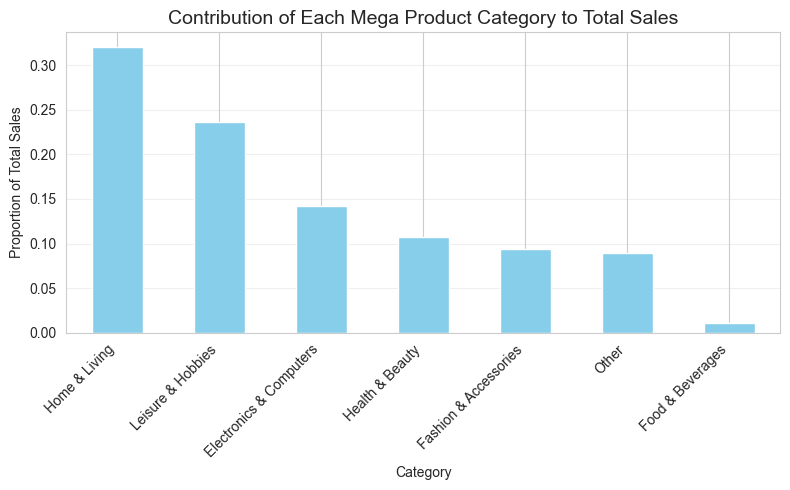

In [193]:
# We first need to merge products with orders to get total_order_value_usd
df_products_merged = df_products.merge(
    df_orders[['order_id', 'total_order_value_usd']],
    on='order_id',
    how='left'
)

# Compute total sales per mega-category
total_sales_by_category = df_products_merged.groupby('product_category_mega')['total_order_value_usd'].sum().sort_values(ascending=False)

# Convert to proportion of grand total
sales_share = total_sales_by_category / total_sales_by_category.sum()

# Plot bar chart
fig, ax = plt.subplots(figsize=(8, 5))
sales_share.plot(kind='bar', color='skyblue', ax=ax)
ax.set_title("Contribution of Each Mega Product Category to Total Sales", fontsize=14)
ax.set_ylabel("Proportion of Total Sales")
ax.set_xlabel("Category")
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Contribution of Product Category PER CLUSTER

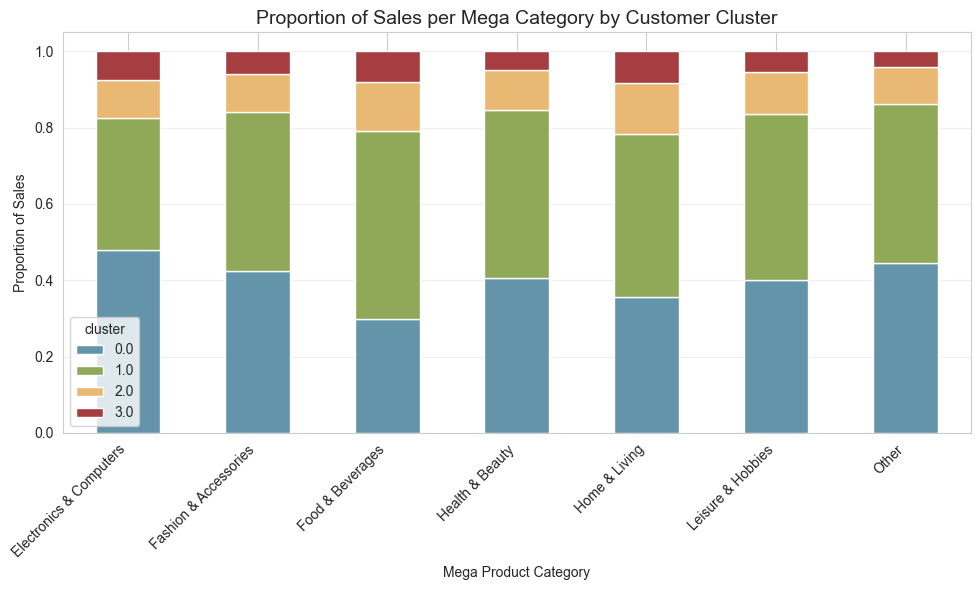

In [194]:
## Are different customer clusters buying different types of products?

# --- Merge products with orders to get total_order_value_usd and cluster
df_products_merged = df_products.merge(
    df_orders[['order_id', 'total_order_value_usd']],
    on='order_id',
    how='left'
)

# --- Compute total sales per mega-category and per cluster
sales_by_category_cluster = (
    df_products_merged
    .groupby(['product_category_mega', 'cluster'])['total_order_value_usd']
    .sum()
    .unstack(fill_value=0)  # each cluster becomes a column
)

# --- Optionally, convert to proportion of category sales
sales_by_category_cluster_prop = sales_by_category_cluster.div(sales_by_category_cluster.sum(axis=1), axis=0)

# --- Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["#6494AA", "#90A959", "#E9B872", "#A63D40"]  # same as your cluster colors
sales_by_category_cluster_prop.plot(kind='bar', stacked=True, ax=ax, color=colors)

ax.set_title("Proportion of Sales per Mega Category by Customer Cluster", fontsize=14)
ax.set_ylabel("Proportion of Sales")
ax.set_xlabel("Mega Product Category")
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Contribution of Product Category Across Time

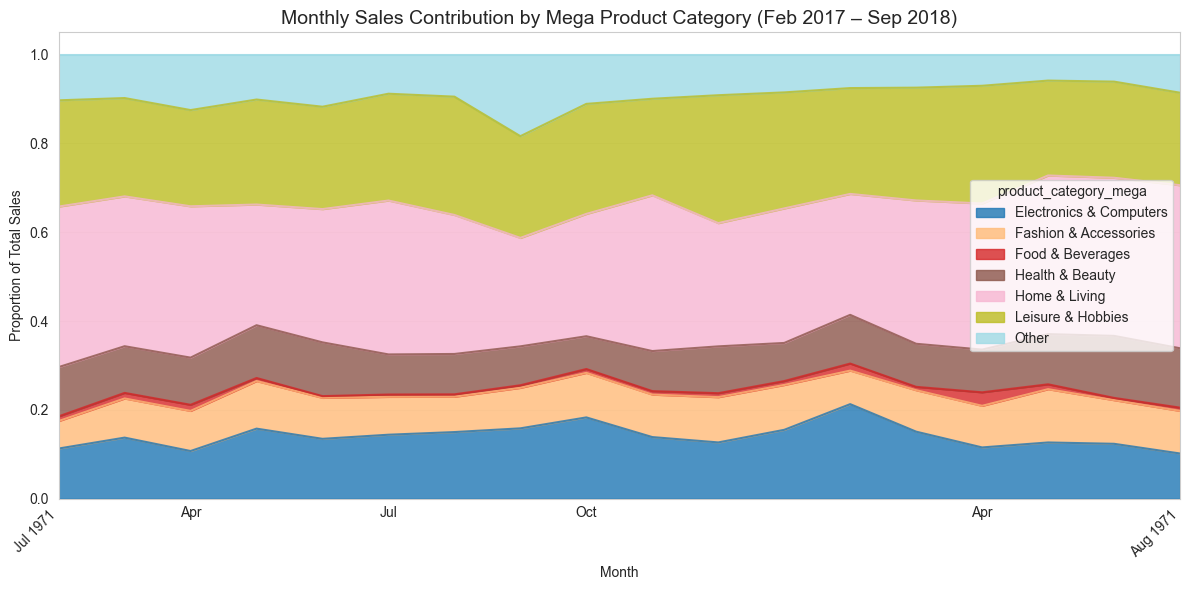

In [195]:
### In order to investigate trend in product across time, we merge the product data with the order data:
# --- Merge product categories into orders
df_orders_products = df_orders.merge(
    df_products[['order_id', 'product_category_mega']],
    on='order_id',
    how='left'
)

# --- Compute total sales per month per mega-category
sales_by_month_category = (
    df_orders_products
    .groupby([pd.Grouper(key='order_purchase_timestamp', freq='ME'), 'product_category_mega'])
    ['total_order_value_usd']
    .sum()
    .reset_index()
    .sort_values('order_purchase_timestamp')
)

# --- Pivot to have categories as columns
sales_pivot = sales_by_month_category.pivot(
    index='order_purchase_timestamp',
    columns='product_category_mega',
    values='total_order_value_usd'
).fillna(0)

# --- Compute total sales per month to get proportions
sales_pivot_prop = sales_pivot.div(sales_pivot.sum(axis=1), axis=0)


# --- Filter to Feb 2017 → Aug 2018 to remove noisy parts
start_date = '2017-02-01'
end_date = '2018-08-30'

sales_pivot_filtered = sales_pivot_prop.loc[start_date:end_date]

# --- Plot stacked area chart
fig, ax = plt.subplots(figsize=(12, 6))
sales_pivot_filtered.plot(kind='area', stacked=True, ax=ax, cmap='tab20', alpha=0.8)

ax.set_title("Monthly Sales Contribution by Mega Product Category (Feb 2017 – Sep 2018)", fontsize=14)
ax.set_xlabel("Month")
ax.set_ylabel("Proportion of Total Sales")
ax.grid(True, alpha=0.3)

# Format x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### ---> the contribution of each category is pretty stable across time